In [41]:
import os
import struct
import numpy as np
import tensorflow
from scipy.sparse import coo_matrix
from sklearn.utils import shuffle
from keras.utils import np_utils

import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
print(np.__version__)

1.14.1


In [43]:
print(tensorflow.__version__)

1.6.0


# 1 . Create training set and test set
### Training set including three part of data
1. 60000 handwritten numbers 
2. 6000 random noise 
3. 6000 handwritten alphabet noise 

In [44]:
def load_data(path, kind=''):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte'
                               % kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',
                                 lbpath.read(8))
        labels = np.fromfile(lbpath,
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII',
                                               imgpath.read(16))
        images = np.fromfile(imgpath,
                             dtype=np.uint8).reshape(len(labels), 784)

    return images, labels

In [45]:
path = './datasets/'

In [46]:
# Handwritten numbers training data

X_train_nums,y_train_nums = load_data(path, kind='train')
X_train = X_train_nums / 255

X_test_nums, y_test_nums = load_data(path, kind='t10k')
X_test_nums = X_test_nums / 255

In [47]:
X_test_nums.shape

(10000, 784)

In [48]:
# Random generate noise

noise_random = np.random.rand(6000,784)

In [49]:
# random take handwritten alphabet from Nist

noise_letters,_ = load_data(path, kind='emnist-letters-train')

idx_letters = np.random.randint(len(noise_letters), size=6000)
print(idx_letters)
noise_letters = noise_letters[idx_letters,:]

noise_letters = noise_letters / 255


[15405 80839 10742 ... 97277  4278 13224]


In [50]:
noise_letters.shape

(6000, 784)

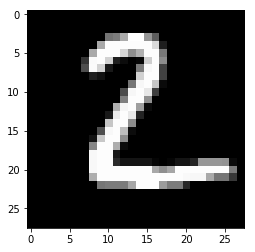

In [51]:
plt.imshow(X_test_nums[1].reshape(28,28),cmap='gray')

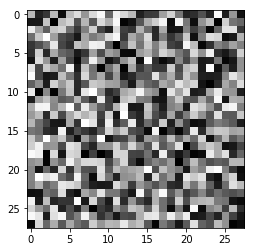

In [52]:
plt.imshow(noise_random[1].reshape(28,28),cmap='gray')

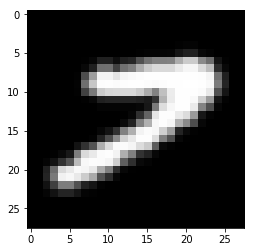

In [53]:
plt.imshow(noise_letters[1].reshape(28,28),cmap='gray')

In [54]:
noise_labels = np.full((6000), 10, dtype=int)
# letters_labels = np.full((6000), 11, dtype=int)

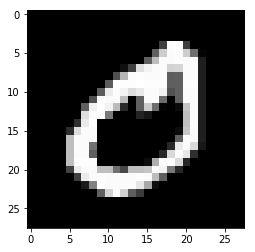

In [55]:
X_train0 = X_train[y_train_nums == 0]
y_train0 = y_train_nums[y_train_nums == 0]
plt.imshow(X_train0[1].reshape(28,28),cmap='gray')

In [56]:
X_train_split = []
y_train_split = []
num_classes = 12 

for i in range(10):

    index_i = np.where( y_train_nums == i )

    X_train_i = X_train[index_i[0],:]
    
    y_train_i = y_train_nums[index_i ]
    
    noise_numbers = X_train
    noise_numbers = np.delete( noise_numbers, index_i, axis = 0 )
    
    idx_noise_numbers = np.random.randint(len(noise_numbers), size=6000)
#     print(idx_noise_numbers)
    noise_numbers = noise_numbers[idx_noise_numbers,:]

    X_train_i = np.concatenate((X_train_i, noise_numbers),axis=0)
#     X_train_i= np.concatenate((X_train_i,noise_letters),axis=0)
    print(X_train_i.shape)

    y_train_i = np.concatenate((y_train_i, noise_labels),axis=0)
#     y_train_i = np.concatenate((y_train_i, letters_labels),axis=0)
    

    
    X_sparse_train = coo_matrix(X_train_i)
    X_train_i, X_sparse_train, y_train_i = shuffle(X_train_i, X_sparse_train, y_train_i, random_state=42)

    X_train_i = X_train_i.reshape(len(X_train_i),1,28,28).astype('float')
    y_train_i = np_utils.to_categorical(y_train_i, num_classes)

    X_train_split.append(X_train_i)
    y_train_split.append(y_train_i)

(11923, 784)
(12742, 784)
(11958, 784)
(12131, 784)
(11842, 784)
(11421, 784)
(11918, 784)
(12265, 784)
(11851, 784)
(11949, 784)


In [57]:
X_train_split[6].shape

(11918, 1, 28, 28)

In [58]:
X_train_split[9][0].shape

(1, 28, 28)

In [59]:
y_train_split[9][0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

In [60]:
X_train[y_train_nums == 0].shape

(5923, 784)

In [61]:
len(y_train_split[0])

11923

In [63]:
y_test.shape

(10000,)

In [64]:
X_test.shape

(10000, 1, 28, 28)

In [65]:
y_test.shape

(10000,)

In [66]:
X_train.shape

(60000, 784)

# 2 . Build Model -- keras model

In [67]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta

K.clear_session()

In [68]:
def models_factory():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', 
                     data_format='channels_first',
                     input_shape=(1, 28, 28)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(12, activation='softmax'))

    model.compile(loss=categorical_crossentropy,
                  optimizer=Adadelta(),
                  metrics=['accuracy'])
    return model

In [69]:
model = models_factory()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 26, 26)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 24, 32)        7520      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 10, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 8, 64)         36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
__________

# 3. Training

In [70]:
from sklearn.metrics import accuracy_score,r2_score
accs = []
history_models = []
models_weights = []

for i in range(10):
    
    print(i)
    model = models_factory()

    X_train=X_train_split[i]
    y_train = y_train_split[i]
    

    history = model.fit(X_train, y_train, epochs=20, batch_size=128, validation_split = 0.1)
    
    weights = model.get_weights()
    history_models.append(history)
    models_weights.append(weights)

    

0
Train on 10730 samples, validate on 1193 samples
Epoch 1/20
10730/10730 [==============================] - 3s 312us/step - loss: 0.3022 - acc: 0.8943 - val_loss: 0.0648 - val_acc: 0.9732
Epoch 2/20
10730/10730 [==============================] - 2s 219us/step - loss: 0.0585 - acc: 0.9788 - val_loss: 0.0543 - val_acc: 0.9832
Epoch 3/20
10730/10730 [==============================] - 2s 221us/step - loss: 0.0405 - acc: 0.9874 - val_loss: 0.0342 - val_acc: 0.9891
Epoch 4/20
10730/10730 [==============================] - 2s 224us/step - loss: 0.0322 - acc: 0.9894 - val_loss: 0.0242 - val_acc: 0.9899
Epoch 5/20
10730/10730 [==============================] - 2s 222us/step - loss: 0.0262 - acc: 0.9915 - val_loss: 0.0178 - val_acc: 0.9933
Epoch 6/20
10730/10730 [==============================] - 2s 225us/step - loss: 0.0212 - acc: 0.9929 - val_loss: 0.0195 - val_acc: 0.9933
Epoch 7/20
10730/10730 [==============================] - 2s 222us/step - loss: 0.0163 - acc: 0.9946 - val_loss: 0.0139 -

10762/10762 [==============================] - 2s 223us/step - loss: 0.0066 - acc: 0.9980 - val_loss: 0.0159 - val_acc: 0.9950
Epoch 20/20
10762/10762 [==============================] - 2s 222us/step - loss: 0.0030 - acc: 0.9989 - val_loss: 0.0184 - val_acc: 0.9967
3
Train on 10917 samples, validate on 1214 samples
Epoch 1/20
10917/10917 [==============================] - 3s 288us/step - loss: 0.4896 - acc: 0.7867 - val_loss: 0.2605 - val_acc: 0.9028
Epoch 2/20
10917/10917 [==============================] - 2s 220us/step - loss: 0.1588 - acc: 0.9437 - val_loss: 0.1113 - val_acc: 0.9654
Epoch 3/20
10917/10917 [==============================] - 2s 220us/step - loss: 0.1021 - acc: 0.9655 - val_loss: 0.0823 - val_acc: 0.9703
Epoch 4/20
10917/10917 [==============================] - 2s 220us/step - loss: 0.0712 - acc: 0.9734 - val_loss: 0.0571 - val_acc: 0.9843
Epoch 5/20
10917/10917 [==============================] - 2s 221us/step - loss: 0.0478 - acc: 0.9836 - val_loss: 0.0351 - val_acc: 

10278/10278 [==============================] - 2s 221us/step - loss: 0.0055 - acc: 0.9983 - val_loss: 0.0869 - val_acc: 0.9764
Epoch 18/20
10278/10278 [==============================] - 2s 222us/step - loss: 0.0051 - acc: 0.9982 - val_loss: 0.0395 - val_acc: 0.9904
Epoch 19/20
10278/10278 [==============================] - 2s 223us/step - loss: 0.0034 - acc: 0.9988 - val_loss: 0.0424 - val_acc: 0.9904
Epoch 20/20
10278/10278 [==============================] - 2s 225us/step - loss: 0.0042 - acc: 0.9983 - val_loss: 0.0413 - val_acc: 0.9895
6
Train on 10726 samples, validate on 1192 samples
Epoch 1/20
10726/10726 [==============================] - 3s 308us/step - loss: 0.4116 - acc: 0.8536 - val_loss: 0.1032 - val_acc: 0.9581
Epoch 2/20
10726/10726 [==============================] - 2s 221us/step - loss: 0.0713 - acc: 0.9776 - val_loss: 0.0557 - val_acc: 0.9799
Epoch 3/20
10726/10726 [==============================] - 2s 221us/step - loss: 0.0418 - acc: 0.9846 - val_loss: 0.0437 - val_acc

10665/10665 [==============================] - 2s 221us/step - loss: 0.0027 - acc: 0.9992 - val_loss: 0.0489 - val_acc: 0.9899
Epoch 16/20
10665/10665 [==============================] - 2s 221us/step - loss: 0.0044 - acc: 0.9985 - val_loss: 0.0458 - val_acc: 0.9874
Epoch 17/20
10665/10665 [==============================] - 2s 222us/step - loss: 0.0025 - acc: 0.9992 - val_loss: 0.0660 - val_acc: 0.9865
Epoch 18/20
10665/10665 [==============================] - 2s 223us/step - loss: 0.0038 - acc: 0.9987 - val_loss: 0.0315 - val_acc: 0.9924
Epoch 19/20
10665/10665 [==============================] - 2s 221us/step - loss: 0.0012 - acc: 0.9996 - val_loss: 0.0435 - val_acc: 0.9882
Epoch 20/20
10665/10665 [==============================] - 2s 226us/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.0456 - val_acc: 0.9890
9
Train on 10754 samples, validate on 1195 samples
Epoch 1/20
10754/10754 [==============================] - 3s 303us/step - loss: 0.5665 - acc: 0.7648 - val_loss: 0.9184 - val_a

In [71]:
len(models_weights)

10

In [72]:
for i in range(10):
    model = models_factory()
    model.set_weights(models_weights[i])
    model.save_weights('./models/magic/my_model_weights' + str(i) + '.h5')

In [73]:
X_test[0].shape

(1, 28, 28)

1. Your model needs be improved (change parameters)
2. You may need to try a different machine learning algorithm (not all algorithms created equal)
3. You need more data (subtle relationship difficult to find)
4. You may need to try transforming your data (dependent upon algorithm used)
5. There may be no relationship between your dependent and independent variables

# 4 . Evaluate & Predict

In [95]:
#  Testing set (mnist testing set)
X_test = X_test_nums
y_test = y_test_nums

X_test  = X_test.reshape(len(X_test),1,28,28).astype('float')
# y_test  = np_utils.to_categorical(y_test,  num_classes)

In [96]:
y_true = []
for i in range(10):

    print( i )
    model = models_factory()
    model.load_weights('./models/magic/my_model_weights' + str(i) + '.h5')
    
    y_pred_i = model.predict( X_test, verbose= 0 )
    
#     print(y_pred_i.shape )
    
    y_pred_i_int = [np.around(x) for x in y_pred_i]
    y_pred_i_max = np.argmax(y_pred_i_int, axis=1)

#     take out index that predict = i 
#     print(y_pred_i_max.shape )
    
    index_i = np.where(y_pred_i_max == i)
    
    X_test = np.delete(X_test, index_i, axis = 0 )
#     print("After delete , X_test.shape  = ")
#     print(X_test.shape)

    
    y_true_i = y_test[index_i]
    
    y_test = np.delete(y_test, index_i)
    print("y_test.shape   = ")
    print(y_test.shape)
    

#     print(index_i)
    
    y_true.append(y_true_i)


0
y_test.shape   = 
(8987,)
1
y_test.shape   = 
(7795,)
2
y_test.shape   = 
(6708,)
3
y_test.shape   = 
(5699,)
4
y_test.shape   = 
(4713,)
5
y_test.shape   = 
(3807,)
6
y_test.shape   = 
(2892,)
7
y_test.shape   = 
(1907,)
8
y_test.shape   = 
(980,)
9
y_test.shape   = 
(25,)


In [75]:
y_true[0]

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [76]:
y_test.shape

(25,)

In [97]:
from sklearn.metrics import accuracy_score,r2_score
accs = []
for i in range(10):
    print(i)
    sizes = y_true[i].size
    
    print(sizes)
    y_pred = np.full(sizes, i)
#     print("Predict --------------------->")
#     print(y_pred)
    
#     print("True------------------------->")

#     print(y_true[i])
    
    acc_i = accuracy_score(y_true[i],y_pred)*100
    print("\n Acc: %.3f "% acc_i )
    accs.append(acc_i)


0
1013

 Acc: 96.347 
1
1192

 Acc: 95.050 
2
1087

 Acc: 93.560 
3
1009

 Acc: 98.018 
4
986

 Acc: 97.972 
5
906

 Acc: 95.364 
6
915

 Acc: 99.454 
7
985

 Acc: 98.477 
8
927

 Acc: 99.353 
9
955

 Acc: 99.686 


In [98]:
accs

[96.34748272458046,
 95.0503355704698,
 93.56025758969642,
 98.01783944499505,
 97.97160243407707,
 95.36423841059603,
 99.4535519125683,
 98.47715736040608,
 99.35275080906149,
 99.68586387434554]

In [99]:
av_acc = np.mean(accs)
av_acc

97.32810801307963

Check the following things when training any type of deep neural network:

1. the data used to calculate training accuracy is not identical to the data used to train your NN. This sounds weird, but possible in practice, especially in case of images, if you don't keep track of what is happening. For example, you train on random patches of images and calculate training accuracy on random patches of same images. It is easy to forget that though they are same images, the patches are randomly selected.
2. More than the values of train and val accuracy, I would be concerned about what you said, "i'm copy pasting a random epoch but all are roughly the same". No, they can't be same. Accuracy at different epochs is mostly different, because network is learning so it is constantly changing its weights. If accuracy goes up then that means it is approaching the minima of the loss function.
I think you should be more concerned about getting a low training accuracy instead of getting a lower training accuracy than the validation accuracy.
3. Do all the sanity checks given here. Read the entire article if possible, it's very good.
4. Make sure you are doing pre-processing in the right manner. For example, make sure that mean over entire training data is zero. For testing data, subtract the mean vector of the training data from each instance of testing data. Don't subtract the mean of testing data from itself. Since, you wouldn't know the mean of testing data at runtime.
4. Check if your loss at the very first epoch makes sense. For example, in a 10-class classification problem, starting loss should be -ln(0.1) = 2.302 (given here).
5. Again, from here, overfit a tiny subset of data and make sure you can achieve zero cost. Full details in the link.
6. If nothing works, just train and test on the same data and see if you can get 90% + accuracy. Otherwise, examine your network more closely by looking at individual layer outputs (given in Keras FAQ) etc.


<a href ="https://github.com/keras-team/keras/issues/1761">maybe solution</a>